# Projekt 2 - Milestone 3 
## Agata Kaczmarek, Maria Kałuska, Marcelina Kurek

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import inspect

from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_mutual_info_score, completeness_score
from sklearn.metrics import calinski_harabasz_score, homogeneity_score, adjusted_rand_score, fowlkes_mallows_score, v_measure_score
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100

In [144]:
df = pd.read_csv('df_corpus_with_labels.csv', index_col=0)

In [145]:
X = df.drop(columns=['label', 'text'])
Y = df.iloc[:, -1]

In [146]:
religions_dict = {'Christianity': 2, 'Hiduism': 3,'Taoism': 1, 'Buddhism': 0}
Y_enc = Y.map(religions_dict)

In [147]:
results = pd.DataFrame()

**Funkcje**

In [148]:
# Funkcja liczy wyniki klastrowania dla różnej liczby klastrów, dla podanego algorytmu klastrowania oraz metryki
def clustering_scores(X, cluster_num, model_class, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [149]:
# Funkcja rysuje lub wypisuje wyniki klastrowania
def plot_clustering_scores(X, cluster_num, model_class, score_funcs):
    if inspect.isfunction(score_funcs):
        score_funcs = [score_funcs]
    
    n = len(score_funcs)
    ncols = 3
    nrows = 1
    fig = plt.figure(figsize=[n * 4, 4])
    for i in range(n):
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f"{str(score_funcs[i].__name__).replace('_', ' ')}")
        
        scores = clustering_scores(X, cluster_num, model_class, score_funcs[i])
        plt.plot(cluster_num, scores, marker='x')
    plt.show()  

In [150]:
def accuracy_score(y_true, y_pred):
    k = len(np.unique(y_pred))
    correctly_clustered = 0
    for i in range(k):
        current_cluster = y_true[y_pred==i]
        bincount = np.bincount(current_cluster)
        most_freq_class = np.argmax(bincount)
        
        correctly_clustered += bincount[most_freq_class]
    return correctly_clustered / len(y_true)        

In [151]:
# Funkcja sprawdza jak sobie dany podział radzi w różnych metrykach
def evaluate_clustering(X, k, model_class, index_suffix=' '):
    metrics_unsupervised = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    metrics_supervised = [accuracy_score, adjusted_rand_score, fowlkes_mallows_score, adjusted_mutual_info_score, homogeneity_score, \
                         completeness_score, v_measure_score]
    
    y_pred = model_class(n_clusters=k).fit_predict(X)
    
    scores = dict()
    
    idx_name = f"{str(model_class.__name__).replace('_', ' ')} {k}" + index_suffix
    
        
    global results 
    if idx_name in results.index:        
        for m in metrics_unsupervised:
            scores[f"{str(m.__name__).replace('_', ' ')}"] = m(X, y_pred)

        for m in metrics_supervised:
            scores[f"{str(m.__name__).replace('_', ' ')}"] = m(Y_enc, y_pred)
        results.loc[idx_name, :] = scores
    else:
        for m in metrics_unsupervised:
            scores[f"{str(m.__name__).replace('_', ' ')}"] = [m(X, y_pred)]
        
        for m in metrics_supervised:
            scores[f"{str(m.__name__).replace('_', ' ')}"] = [m(Y_enc, y_pred)]

        scores = pd.DataFrame(scores)
        scores = scores.rename(index={0: idx_name})
        results = results.append(scores)

# 1. KMeans

In [152]:
cluster_num = list(range(2,12))

## 1.1 Dobór liczby klastrów
Z wcześniejszego notatnika wiemy, że optymalnym podziałem na klastry według metryk był podział na 3 lub 2 klastry.

Z kolei korzystając z wiedzy o tym, że teksty pochodzą z czterech religii, oprócz powyżej wspomianego podziału będziemy  oceniać poprawność podziału na 4 klastry.

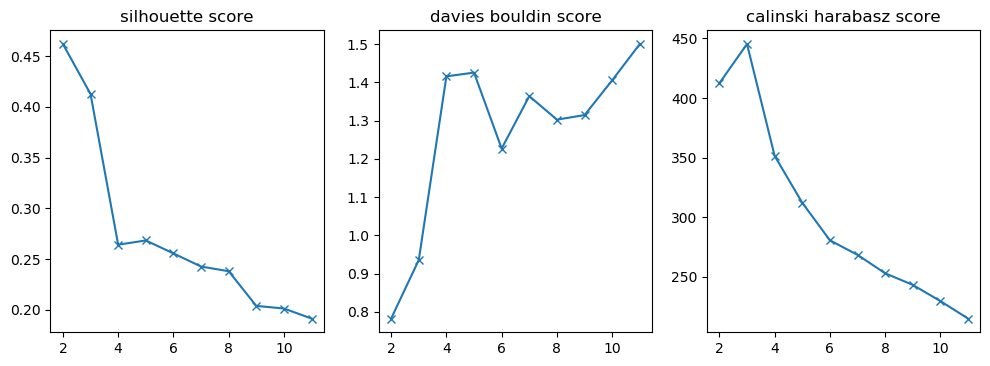

In [153]:
plot_clustering_scores(X, cluster_num, KMeans, [silhouette_score, davies_bouldin_score, calinski_harabasz_score])

**Przypomnienie**

Dla metryki Silhouette oraz metryki Calińskiego-Harabasza wyższy wynik oznacza lepszy podział, w przypadku punktacji Daviesa Bouldina jest odwrotnie.

Zatem możemy zaobserwować, iz najlepszym podziałem będzie rozdzielenie obserwacji na 2 lub 3 klastry.

In [154]:
cluster_num_chosen = [2, 3, 4]

## 1.2 Sprawdzenie jakości podziału

**Wykorzystane metryki**

1. Silhouette score - mierzy średnie odległości wewnąrz klastra oraz odleglości od najbliższego klastra. 1 - dobry wynik, -1 zły. Bliskie 0 to nakładające się klastry, a ujemne wartości to informacja, że nastapiło przypisanie do niewłaściwego klastra.
2. Davies bouldin score - mierzy podobieństwo klastra z jego najbardziej podobnym klastrem. 0 - lepszy wynik.
3. Calinski harabasz score - stosunek rozproszenia w klastrach a pomiędzy klastrami.
4. Accuracy score - mierzy dokładność predykcji - etykiety przewidziane muszą dokładnie pasować do etykiet danych, 1 - wynik dobry, 0 - zły.
5. Adjusted rand score - mierzy podobieństwo dwóch klasteryzacji, 1 - dobry wynik, 0 - zły wynik.
6. Fowlkes mallows score - mierzy podobieństwo dwóch klasteryzacji, wynik 1 oznacza, że podział jest identyczny w obu przypadkach, 0 oznacza, że podziały znacząco się różnią.
7. Adjusted mutual Information - mierzy zgodność miedzy klasteryzacjami, 1 oznacza najlepszy możliwy wynik
8. Homogenity (jednolitość) - mierzy czy w każdy klaster zawiera obserwacje z tylko jednej klasy, 1 - świetny wynik, 0 - zły wynik.
9. Completeness score -  mierzy czy wszystkie obserwacje z jednej klasy należą do tego samego klastra, 1 - dobry wynik, 0 - zły wynik.
10. V measure score - średnia harmoniczna z homogeneity i completeness, 1 - dobry wynik, 0 - zły wynik. 

In [155]:
evaluate_clustering(X, 2, KMeans)
evaluate_clustering(X, 3, KMeans)
evaluate_clustering(X, 4, KMeans)

In [156]:
results

,silhouette score,davies bouldin score,calinski harabasz score,accuracy score,adjusted rand score,fowlkes mallows score,adjusted mutual info score,homogeneity score,completeness score,v measure score
KMeans 2,0.461878,0.782562,412.425657,0.774576,0.464863,0.762999,0.379509,0.380968,0.834355,0.523092
KMeans 3,0.412654,0.935582,445.316105,0.822034,0.580912,0.759515,0.526466,0.528694,0.608545,0.565816
KMeans 4,0.264108,1.424702,351.501325,0.827119,0.363100,0.583532,0.440372,0.547245,0.443573,0.489986


In [157]:
y_pred = KMeans(n_clusters=2).fit_predict(X)

# 2. KMeans z PCA

**Wyjaśnienie wariancji**

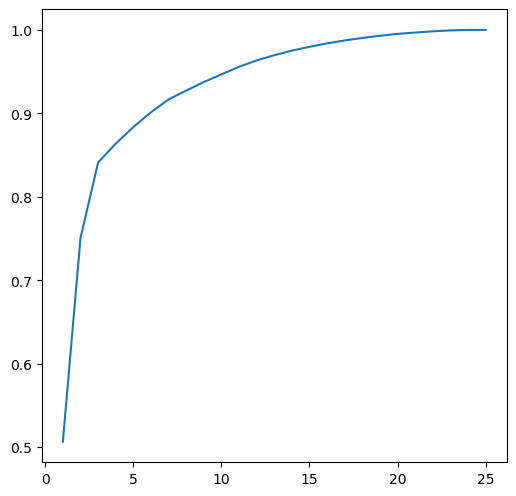

In [158]:
pca = PCA(n_components=25)
pca.fit(X)
plt.figure(figsize=[6, 6])
plt.plot(np.arange(1, 26),np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [159]:
pca2 = PCA(n_components=2)
pca2.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## 2.1 Dobór liczby klastrów
Po zastosowaniu PCA proponowana liczba klastrów to ponownie 3.

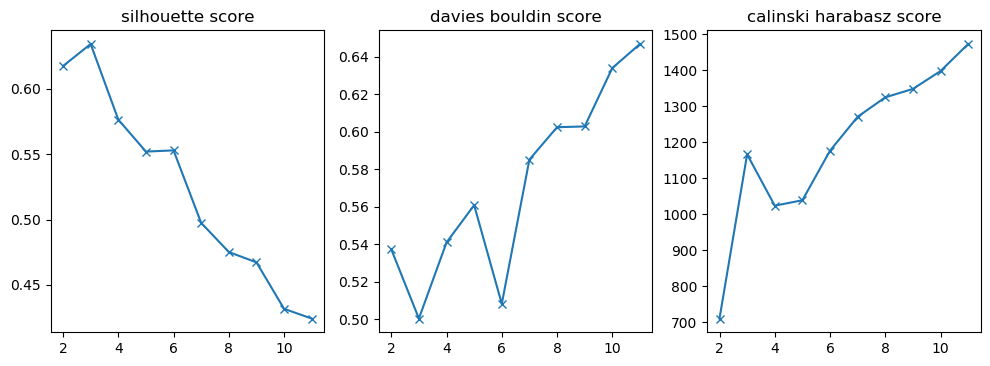

In [160]:
X_2 = pca2.transform(X)
plot_clustering_scores(X_2, cluster_num, KMeans, [silhouette_score, davies_bouldin_score, calinski_harabasz_score])

## 2.2 Wizualizacja 2D

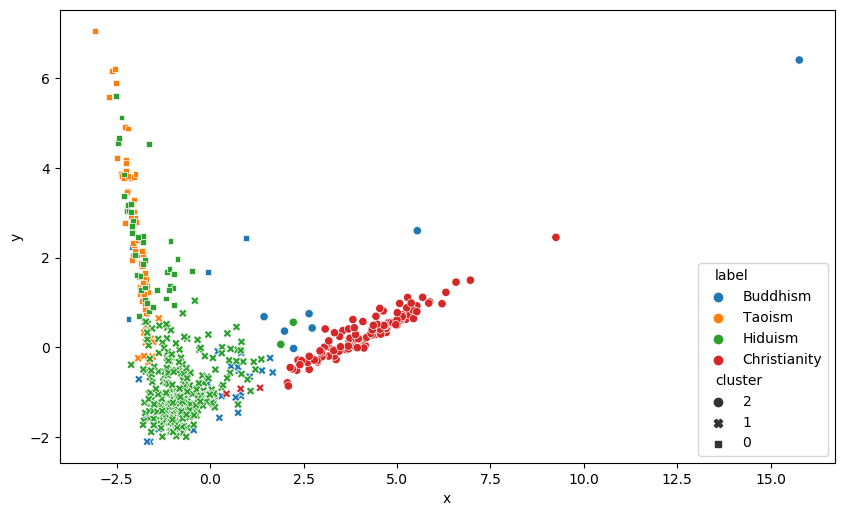

In [161]:
X_2df = pd.DataFrame({'x': X_2[:, 0], 'y': X_2[:, 1], 
                     'label': Y, 
                     'cluster': KMeans(n_clusters=3).fit_predict(X_2).astype('str')})

plt.figure(figsize=[10, 6])
sns.scatterplot(data=X_2df, x='x', y='y', hue='label', style='cluster')
plt.show()

## 2.3 Sprawdzenie jakości podziału

In [162]:
evaluate_clustering(X_2, 2, KMeans, index_suffix='PCA 2')
evaluate_clustering(X_2, 3, KMeans, index_suffix='PCA 2')
evaluate_clustering(X_2, 4, KMeans, index_suffix='PCA 2')
results

,silhouette score,davies bouldin score,calinski harabasz score,accuracy score,adjusted rand score,fowlkes mallows score,adjusted mutual info score,homogeneity score,completeness score,v measure score
KMeans 2,0.461878,0.782562,412.425657,0.774576,0.464863,0.762999,0.379509,0.380968,0.834355,0.523092
KMeans 3,0.412654,0.935582,445.316105,0.822034,0.580912,0.759515,0.526466,0.528694,0.608545,0.565816
KMeans 4,0.264108,1.424702,351.501325,0.827119,0.363100,0.583532,0.440372,0.547245,0.443573,0.489986
KMeans 2PCA 2,0.617518,0.537387,710.080962,0.774576,0.470411,0.764587,0.378439,0.379901,0.824334,0.520106
KMeans 3PCA 2,0.634361,0.500457,1166.129308,0.820339,0.580549,0.759007,0.518735,0.520999,0.598526,0.557078
KMeans 4PCA 2,0.576489,0.541037,1023.605177,0.803390,0.543442,0.725487,0.510645,0.537686,0.513978,0.525565


# Wnioski dla KMeans

Zastosowanie PCA nie zmniejszyło w znaczący sposób jakości klasteryzacji. W przypadku metryk do uczenia nienadzorowanego wyniki wzrosły po zastosowaniu PCA. Zatem można powiedzieć, że skorzystanie z PCA jest zalecane, ponieważ nie tracimy na jakości klasteryzacji, a zyskujemy na interpretowalności.

Patrząc głównie na accuracy score  i uwzględniając pozostałe metryki widzimy, że najlepszy jest podział na 3 klastry, po skorzystaniu z PCA.

# 3. Agglomerative Clustering
## 3.1 Dobór liczby klastrów

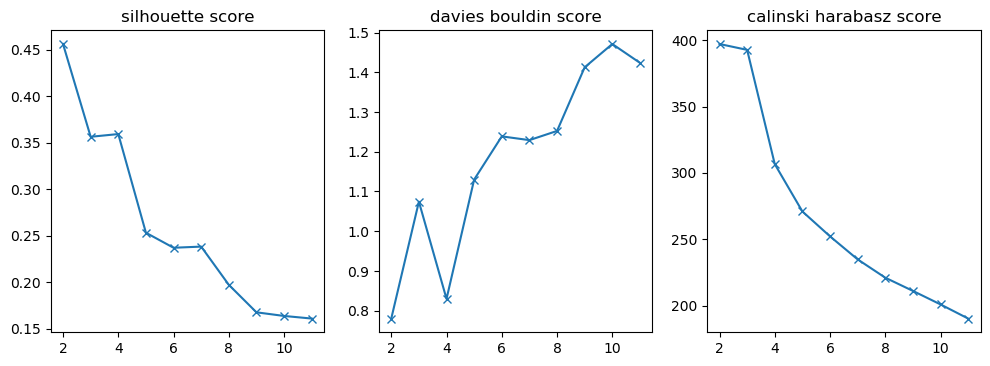

In [163]:
plot_clustering_scores(X, cluster_num, AgglomerativeClustering, [silhouette_score, davies_bouldin_score, calinski_harabasz_score])

Według każdej z wykorzystanych metryk najbardziej optymalny podział zawiera 2 klastry.  
Metryka Silhouette oraz indeks Daviesa-Bouldina wskazuje podział na 4 klastry jako lepszy od podziału na 3 klastry - co pokrywa się z podziałem tekstów na 4 religie.

## 3.2 Sprawdzenie jakości podziału

In [164]:
evaluate_clustering(X, 2, AgglomerativeClustering)
evaluate_clustering(X, 3, AgglomerativeClustering)
evaluate_clustering(X, 4, AgglomerativeClustering)

In [165]:
results

,silhouette score,davies bouldin score,calinski harabasz score,accuracy score,adjusted rand score,fowlkes mallows score,adjusted mutual info score,homogeneity score,completeness score,v measure score
KMeans 2,0.461878,0.782562,412.425657,0.774576,0.464863,0.762999,0.379509,0.380968,0.834355,0.523092
KMeans 3,0.412654,0.935582,445.316105,0.822034,0.580912,0.759515,0.526466,0.528694,0.608545,0.565816
KMeans 4,0.264108,1.424702,351.501325,0.827119,0.363100,0.583532,0.440372,0.547245,0.443573,0.489986
KMeans 2PCA 2,0.617518,0.537387,710.080962,0.774576,0.470411,0.764587,0.378439,0.379901,0.824334,0.520106
KMeans 3PCA 2,0.634361,0.500457,1166.129308,0.820339,0.580549,0.759007,0.518735,0.520999,0.598526,0.557078
KMeans 4PCA 2,0.576489,0.541037,1023.605177,0.803390,0.543442,0.725487,0.510645,0.537686,0.513978,0.525565
AgglomerativeClustering 2,0.456230,0.780209,397.107290,0.783051,0.479725,0.772234,0.425413,0.426764,0.948163,0.588601
AgglomerativeClustering 3,0.356460,1.074349,392.690926,0.801695,0.544160,0.730392,0.607180,0.609025,0.668815,0.637521
AgglomerativeClustering 4,0.359384,0.829750,306.650040,0.803390,0.545387,0.730973,0.613285,0.615760,0.669681,0.641589


Metryki porównujące prawdziwe wartości kolumny `labels` z wartościami predykcyjnymi wypadają korzystniej dla algorytmu AgglomerativeClustering niż bazowego KMeans. 
Z kolei metryki nie wykorzystujące rzeczywistych wartości w kolumnie labels wypadają lepiej dla bazowego modelu KMeans.

Podział na 2 klastry spowodował znaczne pogorszenie Completeness Score (z 0.94 do 0.66) oraz polepszenie wyników dla wszystkich pozostałych metryk (wykorzystujących `true labels`) z wyjątkiem fowlkes mallows score.

# Agglomerative Clustering z PCA
## 4.1 Dobór liczby klastrów 

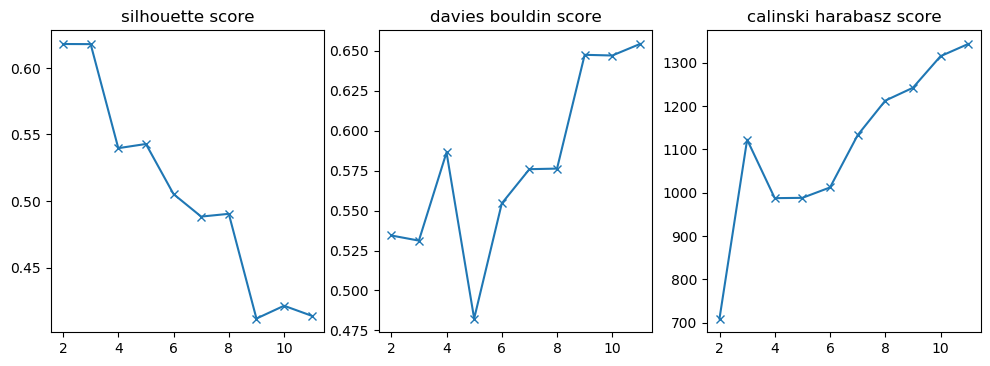

In [166]:
X_2 = pca2.transform(X)
plot_clustering_scores(X_2, cluster_num, AgglomerativeClustering, [silhouette_score, davies_bouldin_score, calinski_harabasz_score])

Optymalna liczba klastrów to 2-3.
## 4.2 Wizualizacja 2D

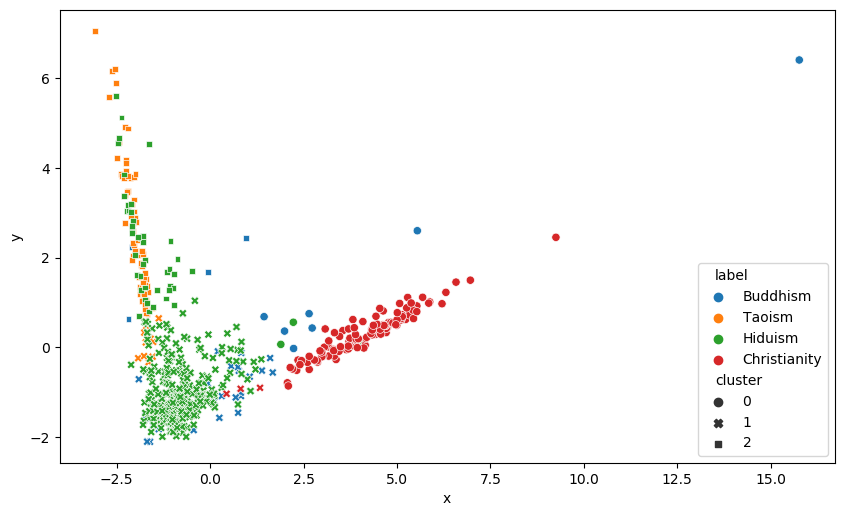

In [167]:
X_2pca = pd.DataFrame({'x': X_2[:, 0], 'y': X_2[:, 1], 
                     'label': Y, 
                     'cluster': KMeans(n_clusters=3).fit_predict(X_2).astype('str')})

plt.figure(figsize=[10, 6])
sns.scatterplot(data=X_2pca, x='x', y='y', hue='label', style='cluster')
plt.show()

## 4.3 Sprawdzenie jakości podziału

In [168]:
evaluate_clustering(X_2, 2, AgglomerativeClustering, index_suffix='PCA 2')
evaluate_clustering(X_2, 3, AgglomerativeClustering, index_suffix='PCA 2')
evaluate_clustering(X_2, 4, AgglomerativeClustering, index_suffix='PCA 2')
results

,silhouette score,davies bouldin score,calinski harabasz score,accuracy score,adjusted rand score,fowlkes mallows score,adjusted mutual info score,homogeneity score,completeness score,v measure score
KMeans 2,0.461878,0.782562,412.425657,0.774576,0.464863,0.762999,0.379509,0.380968,0.834355,0.523092
KMeans 3,0.412654,0.935582,445.316105,0.822034,0.580912,0.759515,0.526466,0.528694,0.608545,0.565816
KMeans 4,0.264108,1.424702,351.501325,0.827119,0.363100,0.583532,0.440372,0.547245,0.443573,0.489986
KMeans 2PCA 2,0.617518,0.537387,710.080962,0.774576,0.470411,0.764587,0.378439,0.379901,0.824334,0.520106
KMeans 3PCA 2,0.634361,0.500457,1166.129308,0.820339,0.580549,0.759007,0.518735,0.520999,0.598526,0.557078
KMeans 4PCA 2,0.576489,0.541037,1023.605177,0.803390,0.543442,0.725487,0.510645,0.537686,0.513978,0.525565
AgglomerativeClustering 2,0.456230,0.780209,397.107290,0.783051,0.479725,0.772234,0.425413,0.426764,0.948163,0.588601
AgglomerativeClustering 3,0.356460,1.074349,392.690926,0.801695,0.544160,0.730392,0.607180,0.609025,0.668815,0.637521
AgglomerativeClustering 4,0.359384,0.829750,306.650040,0.803390,0.545387,0.730973,0.613285,0.615760,0.669681,0.641589
AgglomerativeClustering 2PCA 2,0.618020,0.534404,709.183499,0.774576,0.467623,0.763783,0.378851,0.380312,0.829040,0.521426


## Wnioski dla AgglomerativeClustering
Dla podziału na 2 klastry wartość indeksu completeness wyniosła aż 0.95  
Zastosowanie metody PCA spowodowało polepsznie indeksu silhouette, daviesa-bouldina oraz calinskiego-harabasza;
z kolei indeks completeness pogorszył się średnio o 0.11  
Wartości pozostałych metryk są porównywalne przed i po zastosowaniu algorytmu PCA.  

# Alternatywne podejście
## 5.1 Przygotowanie danych

In [169]:
df_labelled = pd.read_csv('AllBooks_baseline_DTM_Labelled.csv')
labels_1=df_labelled.iloc[:,0]
without_labels=df_labelled.drop(df_labelled.columns[0], axis=1)


In [170]:
changed_labels_4=labels_1.apply(lambda x: 0 if 'Buddhism' in x else (1 if 'TaoTeChing' in x else (2 if 'Upanishad' in x else
(2 if 'YogaSutra' in x else(3 if 'BookOfProverb' in x else(3 if 'BookOfEcclesiastes' in x else (3 if 'BookOfEccleasiasticus' in x else(3 if 'BookOfWisdom' in x else x)))))))).to_frame()

changed_labels_4=changed_labels_4.to_numpy()

In [171]:
df_4 = {'text':[], 'label':[]}
df_4 = pd.DataFrame(data=df_4)
for i in range (df_labelled.shape[0]): #tyle jest obserwacji
    a=""
    for col in without_labels.columns:
        val = without_labels[col].values[i]
        if(val!=0):
            a+=int(val)* (str(col)+" ")
    new_row={'text': a, 'label': changed_labels_4.flat[i]}
    df_4=df_4.append(new_row, ignore_index=True)

In [172]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df_4.text.values)
features = vec.transform(df_4.text.values)
random_state=0
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

## 5.2 Dobór liczby klastrów

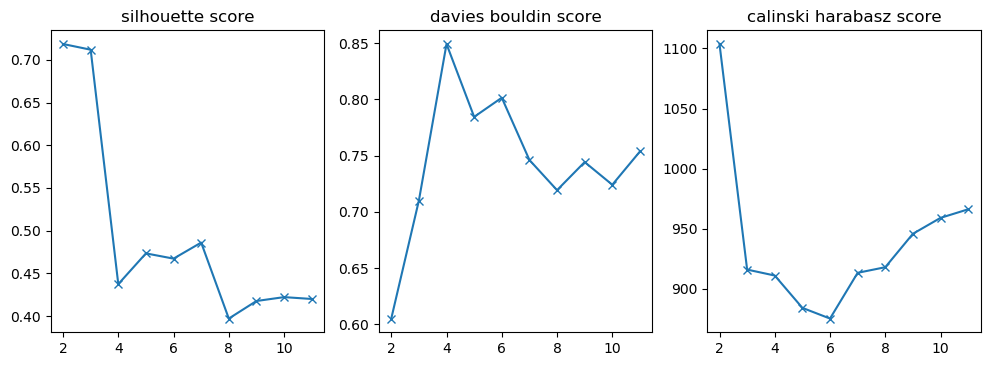

In [173]:
cluster_num = list(range(2,12))
plot_clustering_scores(reduced_features, cluster_num, KMeans, [silhouette_score, davies_bouldin_score, calinski_harabasz_score])

Podobnie jak dla poprzednich algorytmów mamy sytuację, gdy nasze metryki twierdzą, że najlepszy podział byłby na 2 lub 3 klastry. My jednak nadal wiemy, że mamy podział na cztery różne religie.

## 5.3 Wizualizacja 2D

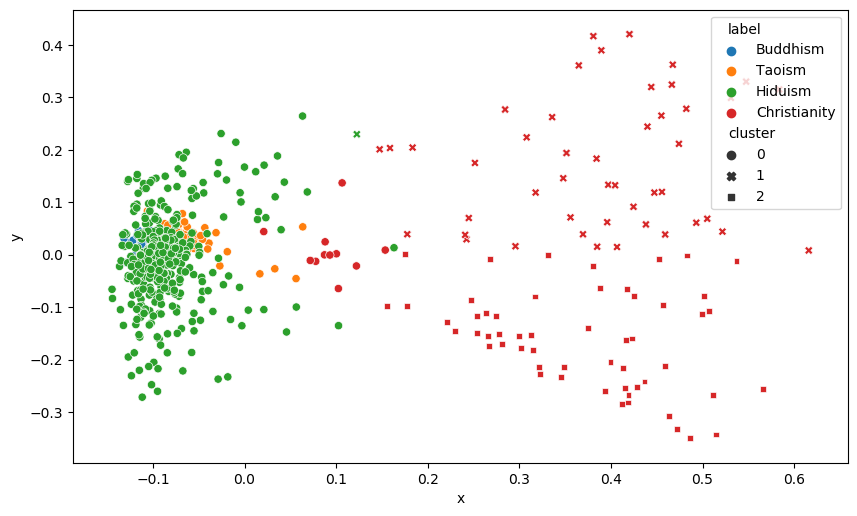

In [174]:
X_2alt = pd.DataFrame({'x': reduced_features[:, 0], 'y': reduced_features[:, 1], 
                     'label': Y, 
                     'cluster': KMeans(n_clusters=3).fit_predict(reduced_features).astype('str')})

plt.figure(figsize=[10, 6])
sns.scatterplot(data=X_2alt, x='x', y='y', hue='label', style='cluster')
plt.show()

## 5.4 Sprawdzenie jakości podziału

In [175]:
evaluate_clustering(reduced_features, 2, KMeans, index_suffix=' alternative 2')
evaluate_clustering(reduced_features, 3, KMeans, index_suffix=' alternative 3')
evaluate_clustering(reduced_features, 4, KMeans, index_suffix=' alternative 4')
results

,silhouette score,davies bouldin score,calinski harabasz score,accuracy score,adjusted rand score,fowlkes mallows score,adjusted mutual info score,homogeneity score,completeness score,v measure score
KMeans 2,0.461878,0.782562,412.425657,0.774576,0.464863,0.762999,0.379509,0.380968,0.834355,0.523092
KMeans 3,0.412654,0.935582,445.316105,0.822034,0.580912,0.759515,0.526466,0.528694,0.608545,0.565816
KMeans 4,0.264108,1.424702,351.501325,0.827119,0.363100,0.583532,0.440372,0.547245,0.443573,0.489986
KMeans 2PCA 2,0.617518,0.537387,710.080962,0.774576,0.470411,0.764587,0.378439,0.379901,0.824334,0.520106
KMeans 3PCA 2,0.634361,0.500457,1166.129308,0.820339,0.580549,0.759007,0.518735,0.520999,0.598526,0.557078
KMeans 4PCA 2,0.576489,0.541037,1023.605177,0.803390,0.543442,0.725487,0.510645,0.537686,0.513978,0.525565
AgglomerativeClustering 2,0.456230,0.780209,397.107290,0.783051,0.479725,0.772234,0.425413,0.426764,0.948163,0.588601
AgglomerativeClustering 3,0.356460,1.074349,392.690926,0.801695,0.544160,0.730392,0.607180,0.609025,0.668815,0.637521
AgglomerativeClustering 4,0.359384,0.829750,306.650040,0.803390,0.545387,0.730973,0.613285,0.615760,0.669681,0.641589
AgglomerativeClustering 2PCA 2,0.618020,0.534404,709.183499,0.774576,0.467623,0.763783,0.378851,0.380312,0.829040,0.521426


# Podsumowanie

Wybieramy trzy metryki wg których będziemy porównywać końcowo nasze wyniki. Są to:
- accuracy score - mierzy dokładność predykcji - etykiety przewidziane muszą dokładnie pasować do etykiet danych, 1 - wynik dobry, 0 - zły.
- fowlkes mallows score - mierzy podobieństwo dwóch klasteryzacji, wynik 1 oznacza, że podział jest identyczny w obu przypadkach, 0 oznacza, że podziały znacząco się różnią.
- completeness score - mierzy czy wszystkie obserwacje z jednej klasy należą do tego samego klastra, 1 - dobry wynik, 0 - zły wynik.

### Podział na dwa klastry.

In [176]:
results.iloc[[0,3,6,9,12],[3,5,8]]

,accuracy score,fowlkes mallows score,completeness score
KMeans 2,0.774576,0.762999,0.834355
KMeans 2PCA 2,0.774576,0.764587,0.824334
AgglomerativeClustering 2,0.783051,0.772234,0.948163
AgglomerativeClustering 2PCA 2,0.774576,0.763783,0.829040
KMeans 2 alternative 2,0.764407,0.746148,0.842345


W tym przypadku pod względem accuracy wszystkie metody wypadły podobnie do siebie, dla fowlkes jest podobnie. Dopiero dla completeness score jest jedna metoda wyróżniająca się bardziej - AgglomerativeClustering.

### Podział na trzy.

In [177]:
results.iloc[[1,4,7,10,13],[3,5,8]]

,accuracy score,fowlkes mallows score,completeness score
KMeans 3,0.822034,0.759515,0.608545
KMeans 3PCA 2,0.820339,0.759007,0.598526
AgglomerativeClustering 3,0.801695,0.730392,0.668815
AgglomerativeClustering 3PCA 2,0.805085,0.736637,0.592039
KMeans 3 alternative 3,0.762712,0.725290,0.664958


W przypadku podziału na trzy klastry pod względem accuracy gorszy wynik uzyskało alternatywne podejście dla KMeans. Dla pozostałych metryk wyniki są bardzo podbobne pomiędzy różnymi metodami.

### Podział na cztery.

In [178]:
results.iloc[[2,5,8,11,14],[3,5,8]]

,accuracy score,fowlkes mallows score,completeness score
KMeans 4,0.827119,0.583532,0.443573
KMeans 4PCA 2,0.803390,0.725487,0.513978
AgglomerativeClustering 4,0.803390,0.730973,0.669681
AgglomerativeClustering 4PCA 2,0.815254,0.730888,0.513247
KMeans 4 alternative 4,0.764407,0.531763,0.435159


Dla podziału na cztery klastry (czyli taka liczba, jaką byśmy chcieli najbardziej) wyniki dla accuracy są podobme, natomiast dla fowlkes oraz completeness gorzej radzą sobie użycia metody KMeans - to bez użycia PCA oraz alternatywne podejście. Tutaj najlepiej również radzi sobie Agglomerative Clustering.

### Ogólne wnioski

Pod względem accuracy większość metod radzi sobie podobnie dobrze, niezależnie od liczby klastrów na ile jest podział. Jednak patrząc na pozostałe metryki możemy wyłonić faworyta - jest to Agglomerative Clustering bez PCA.